# Chapter 8.3 - Neural Style Transfer

In [1]:
from keras.preprocessing.image import load_img, img_to_array
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
target_image_path = './data/Chapter 8.3 - Neural Style Transfer/target_image.jpg'
style_image_path = './data/Chapter 8.3 - Neural Style Transfer/style_image.jpg'

In [3]:
target_image = load_img(target_image_path)
target_image.size

(1600, 1066)

In [4]:
width, height = target_image.size

In [5]:
img_height = 300
img_width = int(width * img_height / height)

## Image preprocessing

In [6]:
import numpy as np
from keras.applications import vgg19

In [7]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size = (img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [8]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
from keras import backend as K

In [10]:
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_image_path))

In [11]:
target_image

<tf.Tensor 'Const:0' shape=(1, 300, 450, 3) dtype=float32>

In [12]:
style_reference_image

<tf.Tensor 'Const_1:0' shape=(1, 300, 450, 3) dtype=float32>

In [13]:
# Placeholder that will contain the generated picture
combination_image = K.placeholder((1, img_height, img_width, 3))

In [14]:
# Combining all three images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], 
                             axis = 0)

In [15]:
# Creating a VGG19 model that takes all three images as input
model = vgg19.VGG19(input_tensor = input_tensor,
                    weights = 'imagenet',
                    include_top = False)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [17]:
# Defining the content loss
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [18]:
# Calculating the Gram Matrix
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [19]:
# Defining the style loss
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [20]:
# Defining total variation loss to avoiding overly pixelated results 
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

To compute the content loss, we only leverage one top layer, the  block5_conv2 layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total variation loss at the end.

In [21]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [22]:
outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 300, 450, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 300, 450, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 150, 225, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 150, 225, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 150, 225, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 75, 112, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 75, 112, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 37, 56, 256) dtype=float32>,
 'bloc

In [23]:
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [24]:
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

In [25]:
# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)

In [26]:
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [27]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [28]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [29]:
evaluator = Evaluator()

In [30]:
from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite
import time

In [31]:
result_prefix = 'style_transfer_result'
iterations = 20

In [32]:
# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, 
                                     x,
                                     fprime = evaluator.grads, 
                                     maxfun = 20)
    print('Current loss value:', min_val)
    # Save current generated image
    # Reshape the flat output as image of h x w x 3 channels
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = './data/Chapter 8.3 - Neural Style Transfer/' + result_prefix + '_at_iteration_%d.png' % i
    imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1018754240.0
Image saved as ./data/Chapter 8.3 - Neural Style Transfer/style_transfer_result_at_iteration_0.png
Iteration 0 completed in 9s
Start of iteration 1
Current loss value: 488565020.0
Image saved as ./data/Chapter 8.3 - Neural Style Transfer/style_transfer_result_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 291247500.0
Image saved as ./data/Chapter 8.3 - Neural Style Transfer/style_transfer_result_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 209897900.0
Image saved as ./data/Chapter 8.3 - Neural Style Transfer/style_transfer_result_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 168201620.0
Image saved as ./data/Chapter 8.3 - Neural Style Transfer/style_transfer_result_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 139299420.0
Image saved as ./data/Chapter 8.3 - Neural Sty

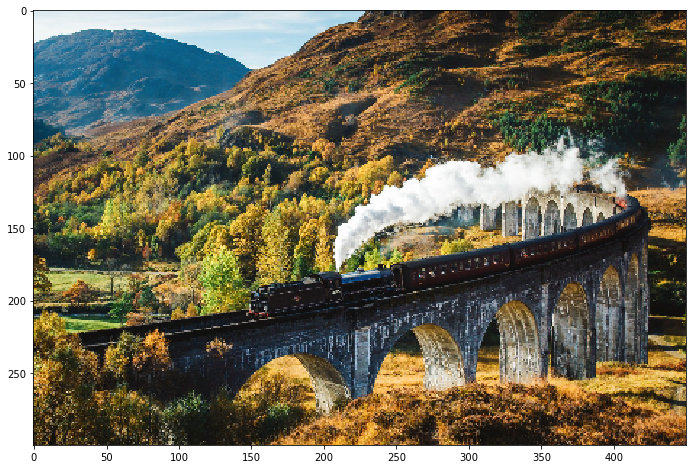

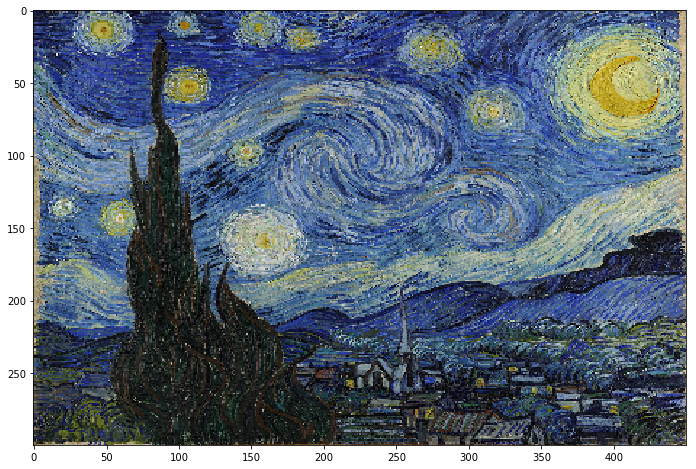

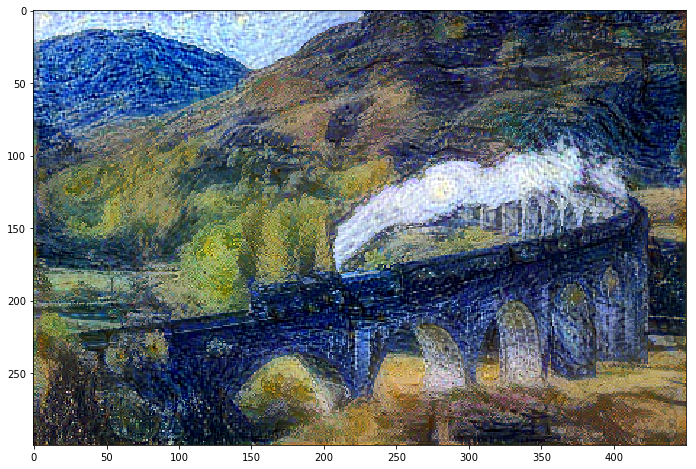

In [33]:
from matplotlib import pyplot as plt

# Content image
plt.figure(figsize = (12, 8))
plt.imshow(load_img(target_image_path, 
                    target_size = (img_height, img_width)))


# Style image
plt.figure(figsize = (12, 8))
plt.imshow(load_img(style_image_path, 
                    target_size = (img_height, img_width)))


# Generate image
plt.figure(figsize = (12, 8))
plt.imshow(img)
plt.show()